<a href="https://colab.research.google.com/github/yash908/My-Jupyter-Notebook/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

This section installs all required dependencies for running SAM2 and
evaluating object detection performance on the CMU10_3D dataset.


In [1]:
# Install core dependencies
!pip install torch torchvision torchaudio
!pip install hydra-core iopath pycocotools opencv-python matplotlib Pillow huggingface_hub


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PATH = "/content/drive/MyDrive/colab"

In [4]:
# Importing Required Libraries
import os
import glob
import shutil
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from PIL import Image
import pandas as pd



In [5]:
os.chdir(PATH)
!git clone https://github.com/facebookresearch/segment-anything-2.git

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.


In [6]:
# Clone & Install SAM2 Locally
%cd segment-anything-2
!pip install -e .
os.chdir(PATH)

/content/drive/MyDrive/colab/segment-anything-2
Obtaining file:///content/drive/MyDrive/colab/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13881 sha256=2cc50dd77c18f84b5c8c25bd58ff962f72b3e7cf30ec7071a474c629564a6d37
  Stored in directory: /tmp/pip-ephem-wheel-cache-161ezsgk/wheels/5c/1f/b7/b6acc1c9fb9b35a02ce418d83914fe7e8a05142a78a53e4b75
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0
[Errno 2] No such file or directory: 'PATH'
/content/drive/MyDrive/colab/segment-anything-2


In [7]:
### Importing SAM2 Modules

from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
print("SAM2 imported successfully ✅")


SAM2 imported successfully ✅


In [14]:
import os

zip_file = "CMU10_3D.zip"

if os.path.exists(zip_file):
    !unzip "$zip_file"
else:
    print("Not exist")


Archive:  CMU10_3D.zip
replace CMU10_3D/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# ================================
# Applicant Implementation Starts Here
# ================================


The following sections implement the solutions to:

1. Problem 1: Dataset handling and zero-shot detection using SAM2
2. Problem 2: Conversion of segmentation masks to bounding boxes
3. Problem 3: Object detection evaluation using COCO metrics


## SAM2 Model Initialization



In [15]:


# === Model paths ===
model_cfg_name = "sam2_hiera_t"  # Hydra wants config name, not full path
checkpoint = "/content/drive/MyDrive/colab/sam2_hiera_tiny.pt"


# === Temp folder ===
tempfolder = "./tempdir"
os.makedirs(tempfolder, exist_ok=True)

# === Device ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# === Load model ===
sam2 = build_sam2(model_cfg_name, checkpoint, device=device, apply_postprocessing=False)
predictor_prompt = SAM2ImagePredictor(sam2)
mask_generator = SAM2AutomaticMaskGenerator(sam2)
predictor_vid = build_sam2_video_predictor(model_cfg_name, checkpoint, device=device)

print("✅ Model loaded successfully!")

Using device: cuda
✅ Model loaded successfully!


## Temporary Directory Utilities


In [16]:
# Temporary directory setup

tempfolder = "./tempdir"
def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)
def cleardir(tempfolder):
    filepaths = glob.glob(tempfolder+"/*")
    for filepath in filepaths:
        os.unlink(filepath)

# Provided Utility: SAM2 Zero-Shot Tracking

In [17]:
# Define Tracking Function

def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)
    shutil.copy(imgpath1, tempfolder + "/00000.jpg")
    shutil.copy(imgpath2, tempfolder + "/00001.jpg")

    inference_state = predictor_vid.init_state(video_path="./tempdir")
    predictor_vid.reset_state(inference_state)

    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        _, out_obj_ids, out_mask_logits = predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )

    video_segments = {}

    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    if visualize:
        fig, ax = plt.subplots()
        plt.title("Original Image")
        ax.imshow(Image.open(tempfolder + "/00000.jpg"))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"detected object in test image ::")
        plt.imshow(Image.open(tempfolder + "/00001.jpg"))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    return video_segments


## Problem 1: Zero-Shot Object Detection Using SAM2

In this section, the first image and its corresponding ground-truth mask
for each product are used to extract a bounding box. This bounding box is
then used to initialize SAM2 in order to detect the same object in all
other images of that product.


### Dataset Sanity Check (Visualization)

The following cell is used to visually inspect multiple images of the same
object category to confirm dataset structure and appearance variations.
This step is for verification purposes only.


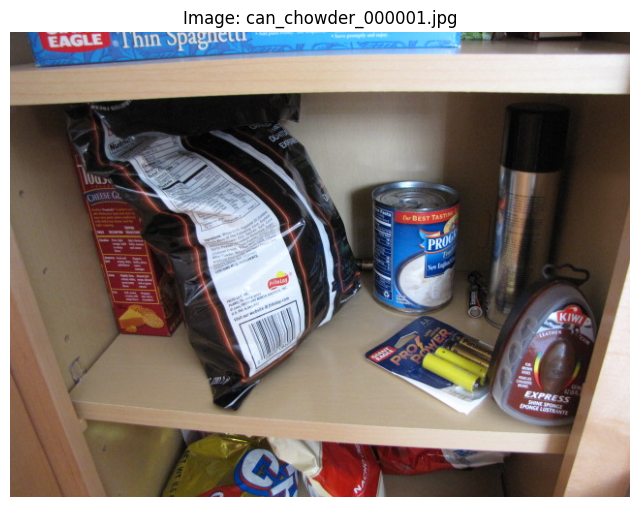

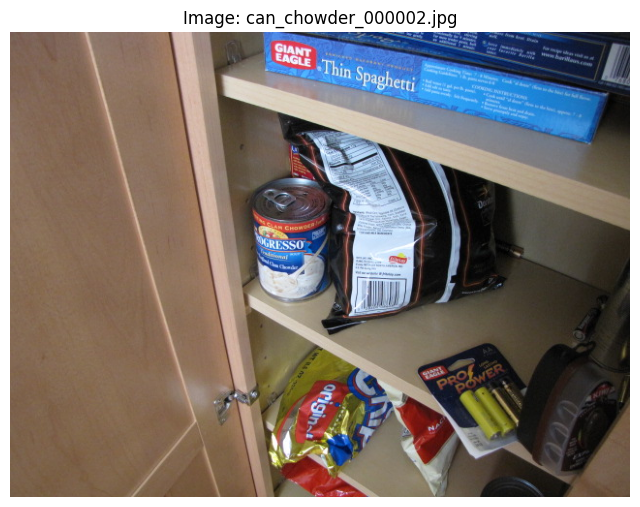

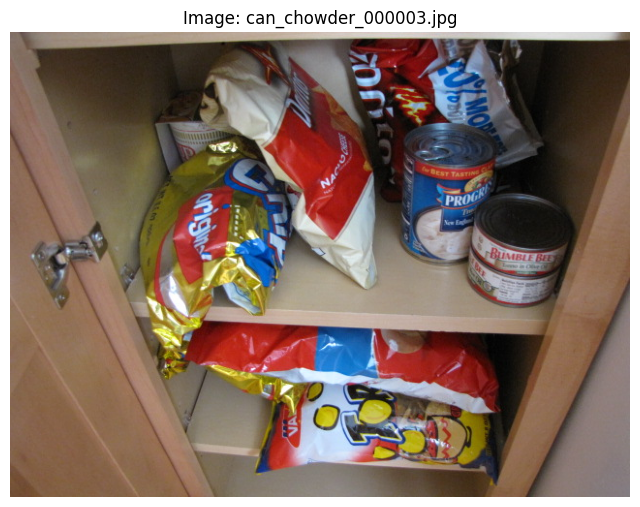

In [18]:
# Display & Check Multiple Images

import matplotlib.pyplot as plt
from PIL import Image

# Your paths
imgpaths = [
    '/content/drive/MyDrive/colab/CMU10_3D/data_2D/can_chowder_000001.jpg',
    '/content/drive/MyDrive/colab/CMU10_3D/data_2D/can_chowder_000002.jpg',
    '/content/drive/MyDrive/colab/CMU10_3D/data_2D/can_chowder_000003.jpg'
]


# Display each image
for path in imgpaths:
    img = Image.open(path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Image: {path.split("/")[-1]}')  # Extracts filename
    plt.axis('off')
    plt.show()

### Dataset Path Verification

This cell verifies that the dataset directory exists and that image and
mask files are accessible. This step is used to ensure correct file paths
before running the SAM2 detection pipeline.


In [19]:
# Verify Dataset Paths
import os
input_dir = '/content/drive/MyDrive/colab/CMU10_3D/data_2D'
output_dir = '/content/drive/MyDrive/colab/CMU10_3D/data_2D'

# Verify files exist
print("Sample files in directory:")
print(os.listdir(input_dir)[:5])


Sample files in directory:
['carton_soymilk_000017_1_gt.png', 'carton_oj_000009.jpg', 'juicebox_000021.jpg', 'diet_coke_000021_2_gt.png', 'rice_tuscan_000004.jpg']


### Object Categories

The following list defines all product categories present in the CMU data_2D
dataset. Each category will be processed independently using a single
annotated image to initialize SAM2.


In [20]:
object_types = [
    'can_chowder', 'can_soymilk', 'can_tomatosoup',
    'carton_oj', 'carton_soymilk', 'diet_coke',
    'hc_potroastsoup', 'juicebox', 'rice_tuscan', 'ricepilaf'
]

In [21]:
input_dir = '/content/drive/MyDrive/colab/CMU10_3D/data_2D'
results = []

for obj in object_types:
    print(f"\n🔍 Processing {obj}...")

# Get reference image and mask paths
    ref_img = f"{input_dir}/{obj}_000001.jpg"
    ref_mask = f"{input_dir}/{obj}_000001_1_gt.png"

# Get bounding box from mask (using provided approach)
    mask = np.array(Image.open(ref_mask))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    ref_box = [x, x+w, y, y+h]

# Process all other images of this type
    all_images = [f for f in os.listdir(input_dir)
                 if f.startswith(obj) and f.endswith('.jpg') and not f.endswith('_000001.jpg')]

    for img_file in all_images:
        target_img = f"{input_dir}/{img_file}"

# Use provided track_item_boxes function
        video_segments = track_item_boxes(
            imgpath1=ref_img,
            imgpath2=target_img,
            img1boxclasslist=[(ref_box, 1)],  # Using object ID=1
            visualize=False)

# Get predicted mask
        pred_mask = video_segments[1][1]  # frame 1, object ID 1

# Save results
        results.append({
            'object': obj,
            'image': img_file,
            'pred_mask': pred_mask,
            'ref_box': ref_box})

print(f"✅ Processed {len(all_images)} images for {obj}")


🔍 Processing can_chowder...


frame loading (JPEG): 100%|██████████| 2/2 [00:00<00:00, 22.85it/s]
/content/drive/MyDrive/colab/segment-anything-2/sam2/sam2_video_predictor.py:786: UserWarning: /content/drive/MyDrive/colab/segment-anything-2/sam2/_C.so: undefined symbol: _ZNK3c1010TensorImpl15incref_pyobjectEv

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]



🔍 Processing can_soymilk...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]



🔍 Processing can_tomatosoup...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]



🔍 Processing carton_oj...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]



🔍 Processing carton_soymilk...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]



🔍 Processing diet_coke...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]



🔍 Processing hc_potroastsoup...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]



🔍 Processing juicebox...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]



🔍 Processing rice_tuscan...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]



🔍 Processing ricepilaf...


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

✅ Processed 49 images for ricepilaf


In [22]:
import pickle

save_path = "/content/drive/MyDrive/colab/sam2_problem1_results.pkl"

with open(save_path, "wb") as f:
    pickle.dump(results, f)

print(f"✅ Results saved to {save_path}")
print(f"Total detections saved: {len(results)}")


✅ Results saved to /content/drive/MyDrive/colab/sam2_problem1_results.pkl
Total detections saved: 490


Problem 1 ends with SAM2 generating segmentation masks for all images,
which are stored for further processing.


## Problem 2: Conversion of SAM2 Output Masks to Bounding Boxes

In this step, the segmentation masks produced by SAM2 are converted into
tight-fitting bounding boxes. These bounding boxes represent the final
object detections and are used for quantitative evaluation.


In [24]:

output_data = []

for result in results:
    pred_mask = result['pred_mask']

    # Ensure mask is 2D
    if pred_mask.ndim == 3:
        pred_mask = pred_mask.squeeze()

    if pred_mask.ndim != 2:
        continue

    rows, cols = np.where(pred_mask)

    if len(rows) == 0:
        continue

    xmin, xmax = int(cols.min()), int(cols.max())
    ymin, ymax = int(rows.min()), int(rows.max())

    output_data.append({
        'object': result['object'],
        'image': result['image'],
        'pred_box': [xmin, xmax, ymin, ymax]
    })

preds_df = pd.DataFrame(output_data)
preds_df.to_csv(f"{input_dir}/sam2_predictions.csv", index=False)

print(f"✅ Saved {len(preds_df)} predicted bounding boxes")
preds_df.head()


✅ Saved 258 predicted bounding boxes


,object,image,pred_box
0,can_chowder,can_chowder_000014.jpg,"[189, 263, 167, 277]"
1,can_chowder,can_chowder_000050.jpg,"[176, 271, 322, 431]"
2,can_chowder,can_chowder_000049.jpg,"[35, 361, 53, 203]"
3,can_chowder,can_chowder_000006.jpg,"[439, 533, 132, 252]"
4,can_chowder,can_chowder_000007.jpg,"[299, 369, 213, 323]"


This completes the conversion of SAM2 segmentation masks into bounding boxes.
In the next step, these predicted bounding boxes are quantitatively evaluated
against ground truth annotations.


## Problem 3: Object Detection Performance Evaluation

In this step, predicted bounding boxes are compared against ground truth
annotations. Detection performance is measured using Intersection over Union (IoU)
and reported per object category.


In [25]:
gt_boxes = []

for _, row in preds_df.iterrows():
    gt_path = f"{input_dir}/{row['image'].replace('.jpg','_1_gt.png')}"

    if not os.path.exists(gt_path):
        continue

    gt_mask = np.array(Image.open(gt_path))
    contours, _ = cv2.findContours(gt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        continue

    x, y, w, h = cv2.boundingRect(contours[0])

    gt_boxes.append({
        'image': row['image'],
        'gt_box': [x, x + w, y, y + h]
    })

gt_df = pd.DataFrame(gt_boxes)
print(f"✅ Extracted {len(gt_df)} ground truth boxes")


✅ Extracted 258 ground truth boxes


In [26]:
merged_df = pd.merge(preds_df, gt_df, on='image')
print(f"✅ Matched {len(merged_df)} predictions with ground truth")


✅ Matched 258 predictions with ground truth


In [27]:
def calculate_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[2], box2[2])
    xB = min(box1[1], box2[1])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[1] - box1[0]) * (box1[3] - box1[2])
    box2_area = (box2[1] - box2[0]) * (box2[3] - box2[2])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

merged_df['IoU'] = merged_df.apply(
    lambda r: calculate_iou(r['pred_box'], r['gt_box']),
    axis=1
)


In [28]:
merged_df['IoU'] = merged_df.apply(
    lambda r: calculate_iou(r['pred_box'], r['gt_box']),
    axis=1
)


In [29]:
print("📊 Mean IoU per object category:")
print(merged_df.groupby('object')['IoU'].mean())

merged_df.to_csv(f"{input_dir}/iou_results.csv", index=False)
print("✅ IoU results saved")


📊 Mean IoU per object category:
object
can_chowder        0.437382
can_soymilk        0.334070
can_tomatosoup     0.358619
carton_oj          0.520536
carton_soymilk     0.439470
diet_coke          0.389319
hc_potroastsoup    0.527625
juicebox           0.672642
rice_tuscan        0.440800
ricepilaf          0.191356
Name: IoU, dtype: float64
✅ IoU results saved
